<a href="https://colab.research.google.com/github/ilanhaskel/Alzheimers_fMRI_Capstone/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain f-MRI Image Classification of Alzheimer's Diagnosis Using Deep Learning Modeling CNNs

Author: Ilan Haskel

## Project Overview

My goal was to create a machine learning model capable of accurately diagnosing the presence of Alzheimer’s when fed an image of a patient’s f-MRI scan. I sought to minimize false-negative diagnoses, those where a patient has Alzheimer’s but the model predicts them to be healthy, all the while maximizing accuracy of predictions. In this way, my model could act as a reliable preliminary screening tool with a strong imperative to prevent patients who actually have Alzheimer’s from slipping through the diagnostic cracks. With this tool in place, diagnosticians and experts would only need to manually analyze imaging scans and conduct further imaging or testing if the model were to return a positive diagnosis. This would not only conserve hospital resources, but allow for more expedient and confident treatment to those diagnosed with Alzheimer’s Disease.

## Business Understanding

Alzheimer's Disease is a degenerative disease that currently has no cure, but can be treated if caught early enough to slow the disease and extend the duration of cognitive function in a given patient. Currently, fMRI (functional Magnetic Resonance Imaging) is but one small, optional piece of a multifaceted diagnostic process.

Tool-assisted interpretations of brain fMRI conducted by radiologists and neurologists in the diagnosis of Alzheimer’s are accurate between 70% and 90% of the time, and this is using a multimodal analysis that takes into account sMRI (structural MRI) and DTI (Diffusion Tensor Imaging) alongside fMRI [[1]](https://www.frontiersin.org/articles/10.3389/fneur.2019.00904/full). The implentation of an fMRI-based CNN machine learning tool in a hospital setting could not only improve accuracy in the diagnosis of AD, but also save hospitals time and money by reducing workloads for radiologists and potentially minimizing the need for other imaging techniques apart from fMRI. If used as a preliminary screening tool tuned to minimize false negative diagnoses of AD, experts would only need to manually analyze imaging scans and conduct further imaging if the model returns a positive diagnosis. This would not only conserve hospital resources, but allow for more expedient and confident treatment for those diagnosed with Alzheimer's Disease.

## Data Understanding

The data I used to train and subsequently test my model consisted of 6400 images of patient fMRI scans collected from several hospitals, websites, and data repositories, all gathered and made publicly available through [Kaggle](https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset). Initially, the data was separated into 4 distinct classes, non-demented (or healthy) brains scans, and three varying degrees of dementia indicating the presence of Alzheimer’s: very mild demented, mild demented, and moderate demented in increasing orders of severity.


## Imports

In [ ]:
import random as python_random
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models, regularizers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
# Setting random seeds for reproducibility
from numpy.random import seed
seed(72)
tf.random.set_seed(72)
python_random.seed(72)


## Disclaimer - Reproducibility

Due to limitations of local computing power (M1 Macs have certain technical difficulties when working with Tensorflow), all model creation and training had to be done using cloud computing via Google Colab. If interested in recreating this notebook, you will need to download the training data from [Kaggle](https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset) and upload it to your personal google drive, placing it in a folder titled 'data'. Within this folder, create separate additional folders for positive and negative alzheimer's diagnoses, and upload the relevant images of each kind into their respective folders. You can also copy [this](https://drive.google.com/drive/folders/1Z6Ro2Kx4_-ZwOhWxn-mzXspU6UnGup8Z?usp=sharing) folder from my own google drive containing the data as it needs to be organized. Furthermore, it appears that the random seeds did not work perfectly, so upon reproduction the models in this notebook are likely to perform marginally different (~0.5% difference in accuracy from personal testing) to the results discussed in the evaluation sections of this notebook.

In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Exploration

Before reading in the data, we import all relevant packages. Since our data consists of images, we utilize the image_dataset_from_directory from Tensorflow. In order to use this data for analysis, the data was instantiated as images and labels and then converted to a Numpy array as it is an easier data type to work with.

In [ ]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/data',
    batch_size=6400,
    seed=42,
    image_size=(256, 256)
)

Found 6400 files belonging to 2 classes.


In [ ]:
images, labels = next(iter(data))

In [ ]:
images, labels = np.array(images), np.array(labels)

In [ ]:
pd.DataFrame(labels).value_counts()

0    3200
1    3200
dtype: int64

In [ ]:
dict_labels = {0:'Healthy', 1:'Demented'}

In [ ]:
percents = np.round(pd.DataFrame(labels).value_counts(normalize=True).sort_index()*100).values

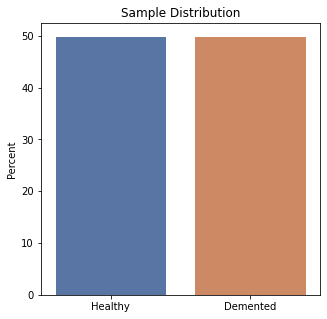

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

sns.set_theme(context='notebook', style='white', font='sans-serif', font_scale = 1)

dist_plot = sns.barplot(x=list(dict_labels.values()), y=percents,ax=ax)
dist_plot.set_title('Sample Distribution')
dist_plot.set_ylabel('Percent');

In [ ]:
images.shape

(6400, 256, 256, 3)

In [ ]:
labels.shape

(6400,)

## Data Preparation

First, we split the data into a training set, a validation set, and a test set in order to begin modeling. Next, we normalized the image matrices.

### Train-Test Split

First we performed a train-test split on the entire dataset, using 70% of the total data for model training. On the remaining 30%, a subsequent train-test split was conducted in order to create a validation set and a holdout test both equal to 15% of our total data. These proportions are generally seen as acceptable given the size of our data.

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(images,
                                                                        labels,
                                                                        test_size=0.3,
                                                                        random_state=42)

In [ ]:
test_images, val_images, test_labels, val_labels = train_test_split(test_images,
                                                                    test_labels,
                                                                    random_state=42,
                                                                    test_size=0.5)

Our training set maintains a near-50% class distribution between healthy and demented.

In [ ]:
pd.DataFrame(train_labels).value_counts(normalize=True)

1    0.502009
0    0.497991
dtype: float64

### Normalize Image Matrices

Since no upsampling is needed, the next step is to normalize the image matrices. Since our images are 256x256 pixels, we divide the entries by 255 to normalize. This process makes each entry's value, or pixel, between 0 and 1.

In [ ]:
train_images, test_images, val_images = train_images/255, test_images/255, val_images/255

## Data Modeling

Before starting the modeling process, we create a function titled ```evaluate``` to visualize the results of each model. This function takes the model, results, and evaluation data, and prints out the following metrics and visualizations: loss for the training and validation sets, AUC for the training and validation sets, accuracy and recall scores for the training and validation sets, and a confusion matrix for the binary classification problem. The function is detailed below.



In [ ]:
def evaluate(model, name, history, X, y, threshold=0.5):
    
    print(f"Results for {name} with threshold = {threshold}.")
    
    plt.rcParams.update({'font.size': 18})
    # Create a function that provides useful vis for model
    # performance. This is especially useful as we are most
    # concerned with the number of false negatives
    
    # Variables for loss and AUC for training and validation data
    train_loss=[value for key, value in history.items() if 'loss' in key.lower()][0]
    valid_loss=[value for key, value in history.items() if 'loss' in key.lower()][1]
    train_auc=[value for key, value in history.items() if 'auc' in key.lower()][0]
    valid_auc=[value for key, value in history.items() if 'auc' in key.lower()][1]
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 15))

    # Plotting loss per epoch for training and validation data
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot(train_loss, color='tab:blue', label='Train Loss')
    ax1.plot(valid_loss, color='tab:orange', label='Valid Loss')
    ax1.legend(loc='upper left')
    ax1.set_ylim([0,1.05])
    plt.title('Model Loss')

    # Plotting AUC per epoch for training and validation data
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('AUC')
    ax2.plot(train_auc, color='tab:blue', label='Train AUC')
    ax2.plot(valid_auc, color='tab:orange', label='Valid AUC')
    ax2.legend(loc='upper left')
    ax2.set_ylim([0.5,1.05])
    plt.title('Model AUC')
        
    # Grabbing our model predictions for use in confusion matrix
    y_pred = model.predict(X)
    y_pred_adjusted = np.zeros([len(y), ])
    i=0
    for pred in y_pred:
        if pred > threshold:
            y_pred_adjusted[i] = 1
            i+=1
        else:
            y_pred_adjusted[i] = 0
            i+=1

    # Plotting confusion matrix
    cm = confusion_matrix(y, y_pred_adjusted)
    cm_df = pd.DataFrame(cm)

    sns.heatmap(cm, ax=ax3, annot=True, cmap='Blues', fmt='0.7g') 

    plt.sca(ax3)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    
    # Printing recall and accuracy for training and validation data
    train_recall=[value for key, value in history.items() if 'recall' in key.lower()][0]
    valid_recall=[value for key, value in history.items() if 'recall' in key.lower()][1]
    train_accuracy=[value for key, value in history.items() if 'accuracy' in key.lower()][0]
    valid_accuracy=[value for key, value in history.items() if 'accuracy' in key.lower()][1]
    
    print(f"\n Train Accuracy: {train_accuracy[-1]} \n Val Accuracy: {valid_accuracy[-1]} \n\n Train Recall: {train_recall[-1]} \n Val Recall: {valid_recall[-1]}")

    # Plotting recall per epoch for training and validation data
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Recall')
    ax4.set_ylim([-0.05,1.05])
    ax4.plot(train_recall, '--', color='tab:orange', label='Train Recall')
    ax4.plot(valid_recall, color='tab:orange', label='Valid Recall')
    ax4.legend(loc='lower left')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

## First Simple Model

For the first model, I chose to use a sequential model. The input layer is a 2D convolutional layer with a 3x3 convolutional window and a dimensionality of 128. The activation used is relu. The next layer (and first hidden layer) is a 2D max pooling layer which downsaples the input and extracts the features with the highest importance. The inclusion of a pooling layer was necessary for performance reasons, and max pooling was chosen specifically for its tendency to perform better in image classification tasks relative to other pooling methods such as average pooling. A flattening layer is added next to compress the output into a single-dimensional matrix, which is then fed into a dense layer with 512 nodes and a relu activation. A dense layer of this dimensionality may cause overfitting, but this can be addressed in future iterations. Finally, our output layer is a dense layer with a sigmoid activation that will squeeze the outputs between 0 and 1, returning the probability that the input belongs to the positive class (Demented) in our binary classification problem.

In [ ]:
# instantiating our input dimensions as a variable for use in the first layer of subsequent models
input_layer = (256,256,3)

In [ ]:
model1 = models.Sequential([
    # Conv2D input layer, making sure to specify input shape
    layers.Conv2D(128, (3,3), activation='relu', input_shape=(input_layer)),
    # apply pooling
    layers.MaxPooling2D(2,2),
    # flatten the result to feed it to the dense layer
    layers.Flatten(), 
    # dense layer with 512 neurons for processing the output coming by the previous layers
    layers.Dense(512, activation='relu'),
    # single output neuron with sigmoid activation function
    layers.Dense(1, activation='sigmoid')  
])

In [ ]:
# Printing model summary as sanity check for model structure
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 128)    0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2064512)           0         
                                                                 
 dense (Dense)               (None, 512)               1057030656
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1,057,034,753
Trainable params: 1,057,034,753
Non-trainable params: 0
______________________________________

In [ ]:
# instantiating list of metrics to be used in model compilation
metrics = ['accuracy', 'AUC', tf.keras.metrics.Recall()]

Before training and evaluating our first model, it must first be compiled. I chose to use `adam` optimization for its computational efficiency and ability to handle large numbers of parameters. `binary_crossentropy` is used for the loss function as it is suitable for binary classification. Accuracy, AUC, and Recall are chosen as evaluation metrics due to their sensitivity towards false negatives and suitability for our business problem. The confusion matrix generated by our `evaluate()` function will also be very useful for evaluation, as it will tell us exactly how many false negatives are present in our model predictions.


In [ ]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=metrics)

After compiling, the model is fit to the training data and its history is extracted and stored as a variable for use in our `evaluate()` function. I chose to train the model with 10 epochs, as training and validation loss seem to bottom out around this point. This effect can be seen in the graph generated by our evaluate() function where model training and validation loss are plotted against number of training epochs. A default batch size of 32 is used in training for the purpose of training efficiency and stability of gradient descent.

In [ ]:
history1=model1.fit(train_images, 
                  train_labels,
                  epochs=10,
                  validation_data=(val_images,val_labels),
                  verbose=2
                  ).history

Epoch 1/10
140/140 - 21s - loss: 2.5221 - accuracy: 0.6583 - auc: 0.6994 - recall: 0.6527 - val_loss: 0.6568 - val_accuracy: 0.5906 - val_auc: 0.8397 - val_recall: 0.2012 - 21s/epoch - 147ms/step
Epoch 2/10
140/140 - 8s - loss: 0.4155 - accuracy: 0.8152 - auc: 0.8978 - recall: 0.8195 - val_loss: 0.3236 - val_accuracy: 0.8625 - val_auc: 0.9481 - val_recall: 0.7906 - 8s/epoch - 55ms/step
Epoch 3/10
140/140 - 8s - loss: 0.2036 - accuracy: 0.9277 - auc: 0.9804 - recall: 0.9280 - val_loss: 0.2274 - val_accuracy: 0.9031 - val_auc: 0.9781 - val_recall: 0.8357 - 8s/epoch - 55ms/step
Epoch 4/10
140/140 - 8s - loss: 0.0840 - accuracy: 0.9759 - auc: 0.9976 - recall: 0.9764 - val_loss: 0.1364 - val_accuracy: 0.9542 - val_auc: 0.9902 - val_recall: 0.9733 - 8s/epoch - 54ms/step
Epoch 5/10
140/140 - 8s - loss: 0.0439 - accuracy: 0.9922 - auc: 0.9997 - recall: 0.9916 - val_loss: 0.1383 - val_accuracy: 0.9458 - val_auc: 0.9934 - val_recall: 0.9097 - 8s/epoch - 55ms/step
Epoch 6/10
140/140 - 8s - loss: 

## First Simple Model - Evaluation

Results for model1 with threshold = 0.5.
30/30 [==============================] - 0s 12ms/step

 Train Accuracy: 1.0 
 Val Accuracy: 0.9833333492279053 

 Train Recall: 1.0 
 Val Recall: 0.987679660320282


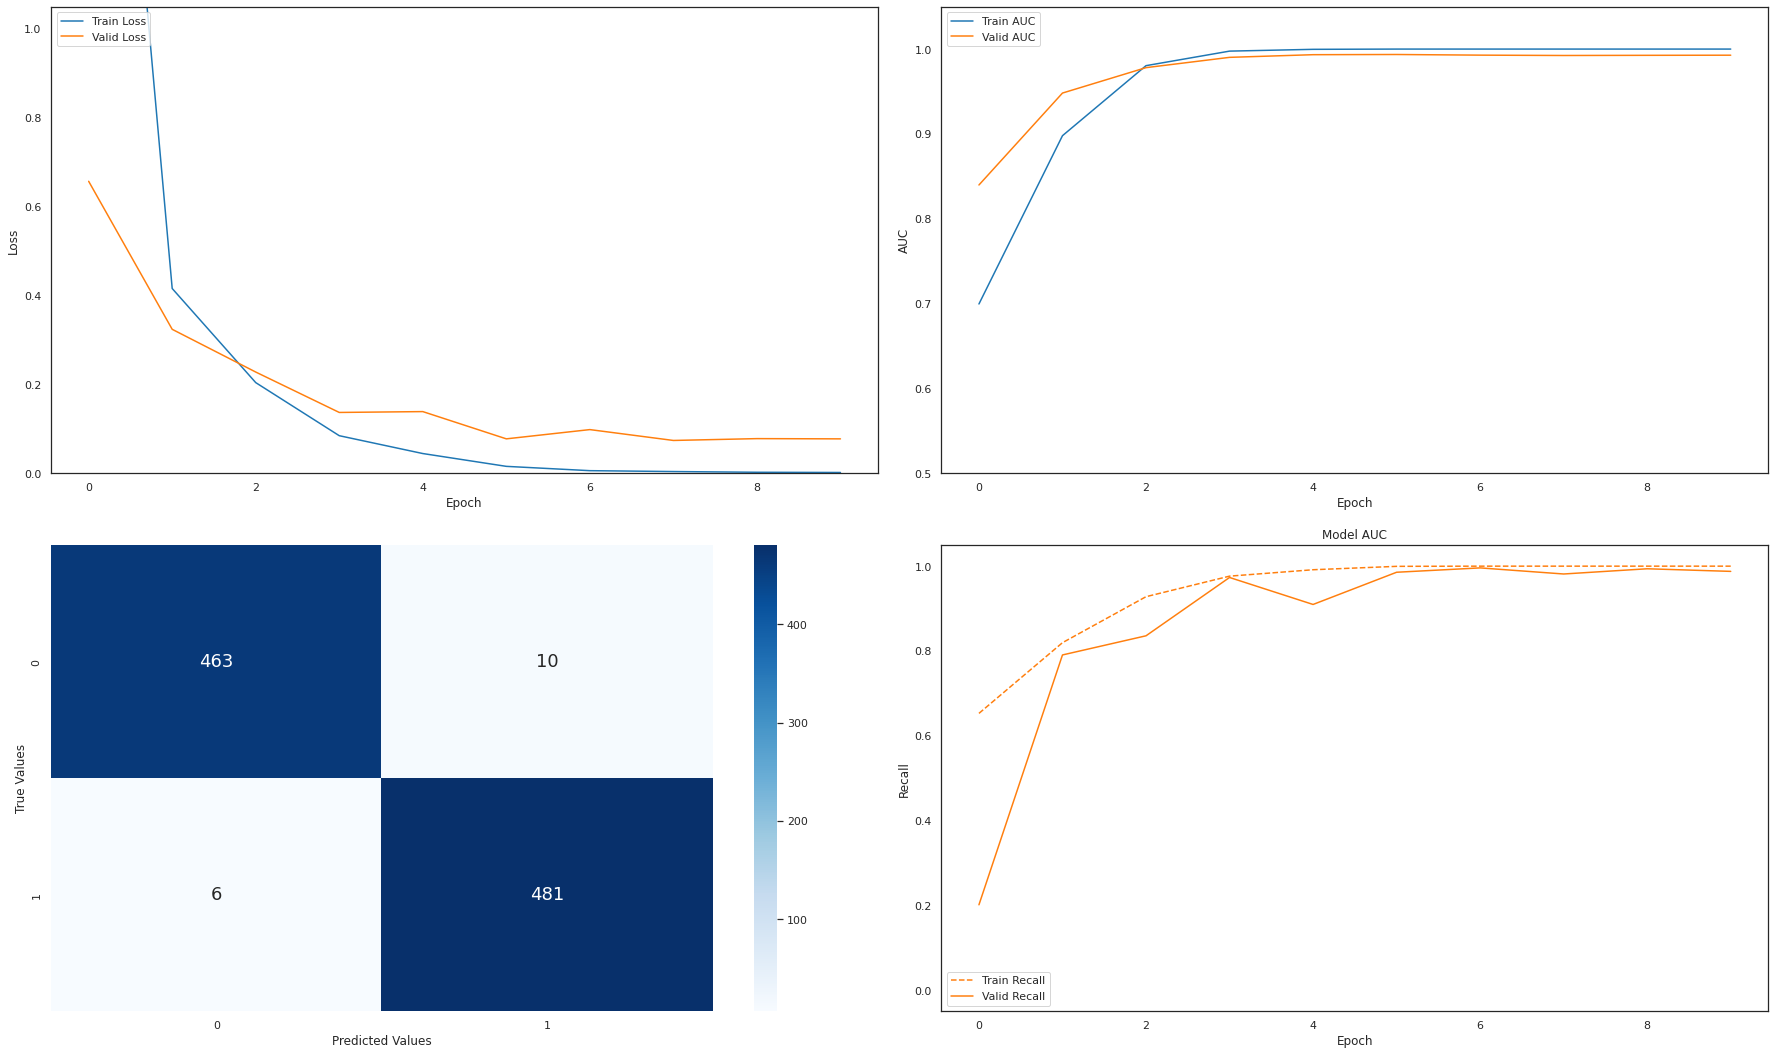

In [ ]:
# using our evaluate function
evaluate(model1, 'model1', history1, X=val_images, y=val_labels, threshold=0.5)

We can see from the above performance metrics and visualizations that this first 'simple' model is already performing remarkably well. When evaluated on validation data, this first model yields an accuracy score of ~98.3%, a recall score of ~98.8%, and an AUC of ~0.99, all of which approach the upper bounds of CNN performance. Furthermore, our confusion matrix shows that our model predictions yielded only 6 false negatives out of the 960 predictions made on validation data. Notably and expectedly, our model is very overfit yielding a perfect accuracy. It may be difficult to prevent on such small margins, but our next iteration will include a 50% dropout layer to try and reduce the overfitting.

## Second Model Iteration


All else staying the same, our second model has a 50% dropout layer before the output layer in order to try and cut back on overfitting.

In [ ]:
model2 = models.Sequential([
    layers.Conv2D(128, (3,3), activation='relu', input_shape=(input_layer)),
    layers.MaxPooling2D(2,2),
    layers.Flatten(), 
    layers.Dense(512, activation='relu'),
    # dropout layer
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  
])

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 128)    0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2064512)           0         
                                                                 
 dense (Dense)               (None, 512)               1057030656
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                        

In [ ]:
metrics

['accuracy', 'AUC', <keras.metrics.metrics.Recall at 0x7f54cb917160>]

In [ ]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=metrics)

In [ ]:
history2=model2.fit(train_images, 
                  train_labels,
                  epochs=10,
                  validation_data=(val_images,val_labels),
                  verbose=2
                  ).history

Epoch 1/10
140/140 - 21s - loss: 4.1713 - accuracy: 0.5725 - auc: 0.5901 - recall: 0.5136 - val_loss: 0.6540 - val_accuracy: 0.6458 - val_auc: 0.7542 - val_recall: 0.4374 - 21s/epoch - 152ms/step
Epoch 2/10
140/140 - 8s - loss: 0.5261 - accuracy: 0.7377 - auc: 0.8158 - recall: 0.7421 - val_loss: 0.3988 - val_accuracy: 0.8135 - val_auc: 0.9053 - val_recall: 0.8172 - 8s/epoch - 54ms/step
Epoch 3/10
140/140 - 8s - loss: 0.3239 - accuracy: 0.8598 - auc: 0.9394 - recall: 0.8648 - val_loss: 0.2741 - val_accuracy: 0.8927 - val_auc: 0.9648 - val_recall: 0.8563 - 8s/epoch - 55ms/step
Epoch 4/10
140/140 - 8s - loss: 0.1797 - accuracy: 0.9393 - auc: 0.9839 - recall: 0.9426 - val_loss: 0.1919 - val_accuracy: 0.9250 - val_auc: 0.9815 - val_recall: 0.9035 - 8s/epoch - 55ms/step
Epoch 5/10
140/140 - 8s - loss: 0.0986 - accuracy: 0.9679 - auc: 0.9956 - recall: 0.9680 - val_loss: 0.1466 - val_accuracy: 0.9479 - val_auc: 0.9914 - val_recall: 0.9158 - 8s/epoch - 55ms/step
Epoch 6/10
140/140 - 8s - loss: 

## Second Model - Evaluation

Results for model2 with threshold = 0.5.
30/30 [==============================] - 0s 12ms/step

 Train Accuracy: 0.9991071224212646 
 Val Accuracy: 0.9864583611488342 

 Train Recall: 0.9995553493499756 
 Val Recall: 0.9856262803077698


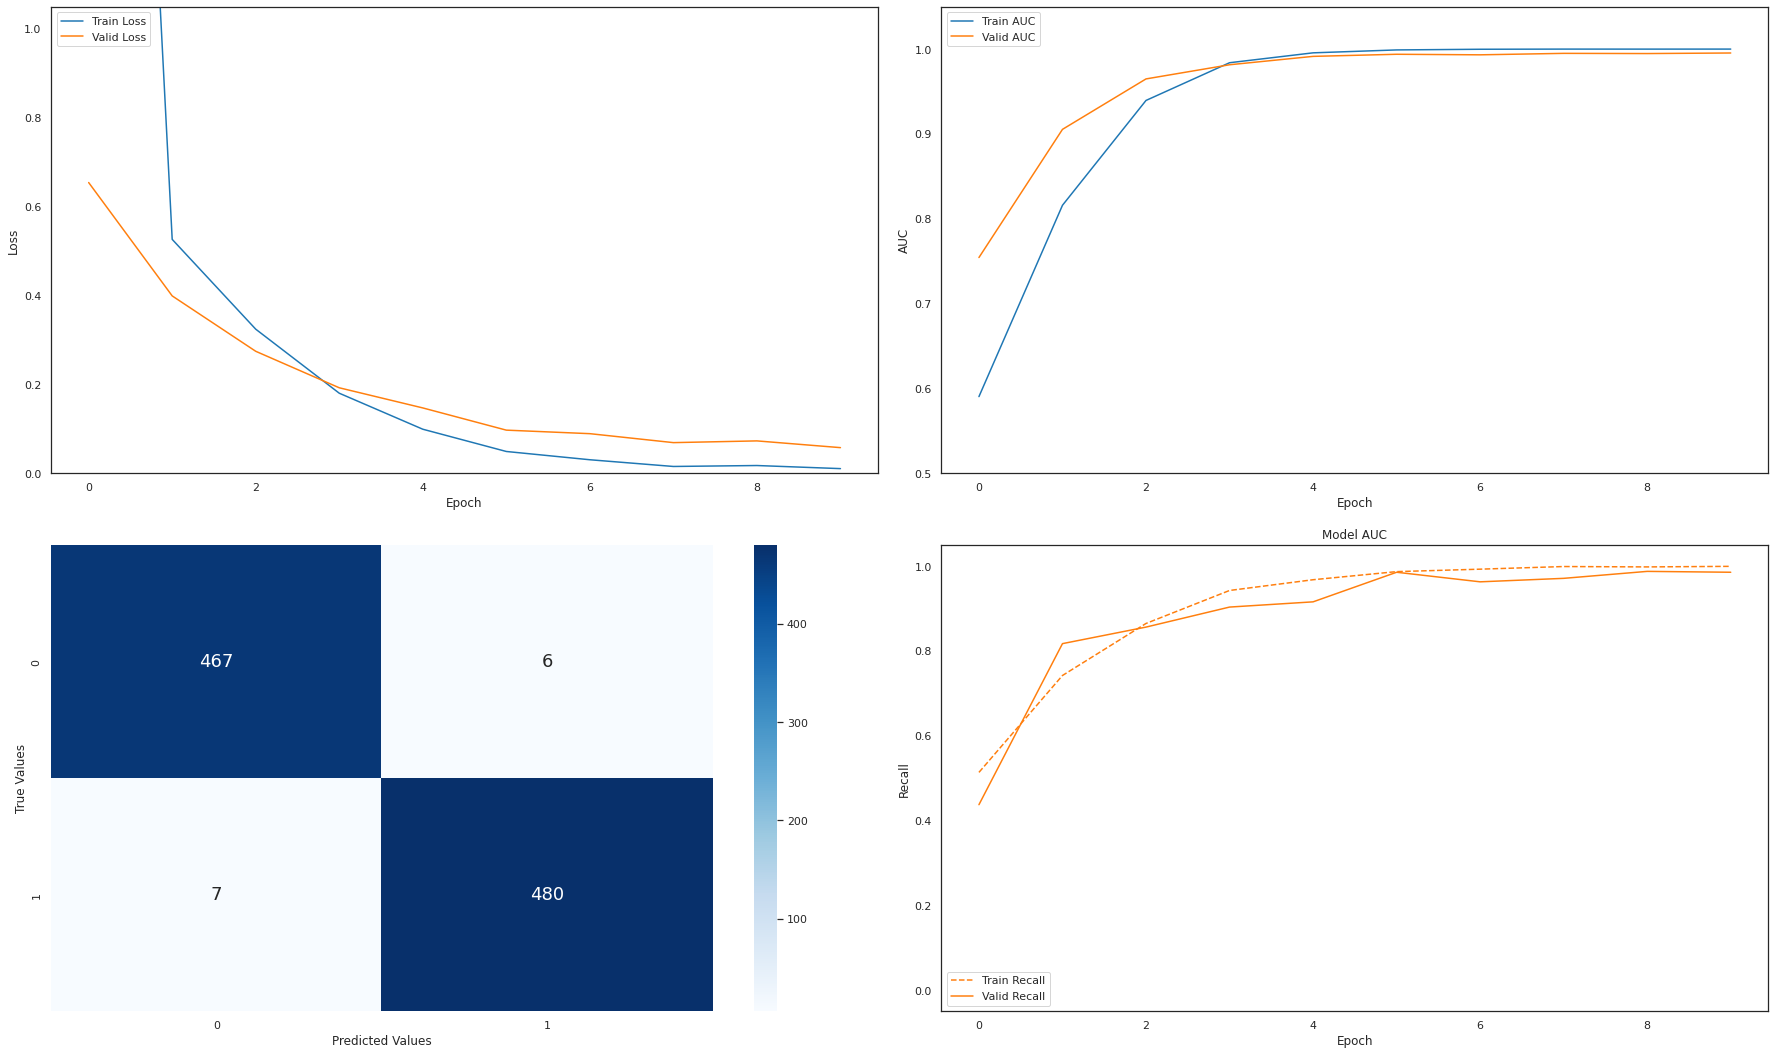

In [ ]:
evaluate(model2, 'model2', history2, X=val_images, y=val_labels, threshold=0.5)

It appears that adding the dropout layer did help alleviate overfitting somewhat. Not only this, but our accuracy also improved slightly. That said, this iteration of the model is performing slightly worse on validation data, specifically in regards to false negatives. It is difficult to tell if this minor variance in performance is due to the construction of the model or the randomness of training, but it is possible that this new model will generalize better to unseen data. 

## Third Model Iteration - Data Augmentation

In an attempt to ensure our model can properly generalize to unseen data, my third model iteration includes two preprocessing layers using some data augmentation techniques - specifically, random flipping and random rotating of images in our dataset. These will create greater diversity among our training images and promote broader generalization to unseen data. The rest of our model will stay the same.

In [ ]:
model3 = models.Sequential([
    # preprocessing layers
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    # ~~~~~
    layers.Conv2D(128, (3,3), activation='relu', input_shape=(input_layer)),
    layers.MaxPooling2D(2,2),
    layers.Flatten(), 
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  
])

model3.build(input_shape=(0,256,256,3))

In [ ]:
model3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_6 (RandomFlip)  (0, 256, 256, 3)          0         
                                                                 
 random_rotation_6 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 conv2d_7 (Conv2D)           (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 127, 127, 128)    0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 2064512)           0         
                                                                 
 dense_14 (Dense)            (None, 512)              

In [ ]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=metrics)

In [ ]:
history3=model3.fit(train_images, 
                  train_labels,
                  epochs=10,
                  validation_data=(val_images,val_labels),
                  verbose=2
                  ).history

Epoch 1/10


140/140 - 18s - loss: 4.0472 - accuracy: 0.5156 - auc: 0.5245 - recall: 0.3951 - val_loss: 0.6894 - val_accuracy: 0.5198 - val_auc: 0.6203 - val_recall: 0.0842 - 18s/epoch - 126ms/step
Epoch 2/10
140/140 - 14s - loss: 0.6857 - accuracy: 0.5547 - auc: 0.5972 - recall: 0.3508 - val_loss: 0.6801 - val_accuracy: 0.5646 - val_auc: 0.6249 - val_recall: 0.4086 - 14s/epoch - 98ms/step
Epoch 3/10
140/140 - 14s - loss: 0.6723 - accuracy: 0.5866 - auc: 0.6226 - recall: 0.5883 - val_loss: 0.6239 - val_accuracy: 0.6833 - val_auc: 0.7275 - val_recall: 0.6776 - 14s/epoch - 98ms/step
Epoch 4/10
140/140 - 14s - loss: 0.6603 - accuracy: 0.6112 - auc: 0.6486 - recall: 0.6278 - val_loss: 0.6673 - val_accuracy: 0.5927 - val_auc: 0.6513 - val_recall: 0.4641 - 14s/epoch - 97ms/step
Epoch 5/10
140/140 - 14s - loss: 0.6314 - accuracy: 0.6533 - auc: 0.6991 - recall: 0.6501 - val_loss: 0.6973 - val_accuracy: 0.5521 - val_auc: 0.6932 - val_recall: 0.1848 - 14s/epoch - 98ms/step
Epoch 6/10
140/140 - 14s - loss: 0.

## Third Model - Evaluation

Results for model3 with threshold = 0.5.
30/30 [==============================] - 0s 13ms/step

 Train Accuracy: 0.6676339507102966 
 Val Accuracy: 0.6427083611488342 

 Train Recall: 0.7109826803207397 
 Val Recall: 0.7700205445289612


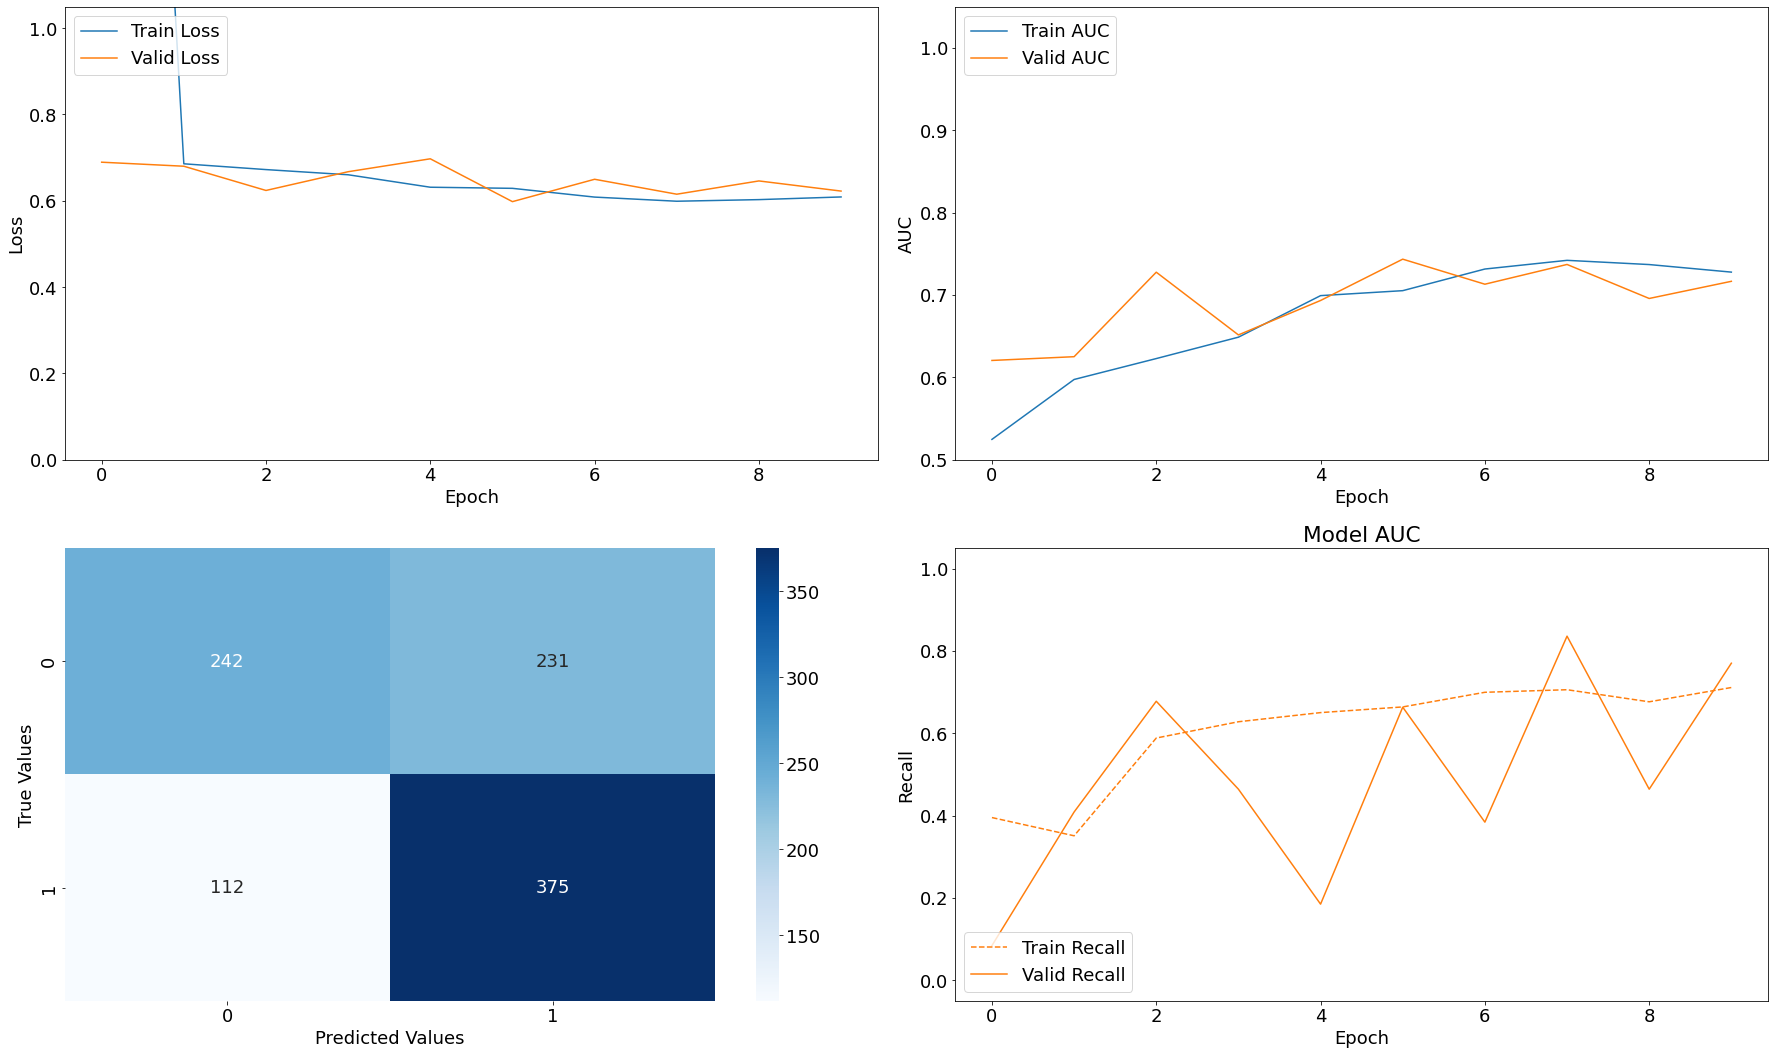

In [ ]:
evaluate(model3, 'model3', history3, X=val_images, y=val_labels, threshold=0.5)

It appears that adding the data augmentation layers have made our model perform significantly worse on both validation and training data across all relevant metrics. Upon doing some research, it is possible that the current version of tensorflow is experiencing some bugs regarding the implementation of data augmentation in Sequential models, so this will not be part of our final model.

## Final Model - Evaluation

It looks like our best-performing model in terms of overfitting and our performance metrics is `model2`, where a dropout layer was added to address the overfitting. We can now evaluate this model on test data before deploying it. I also made sure to add some preprocessing layers that resize and rescale images such that images of any size can be run through the model once deployed.

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(256, 256, input_shape=input_layer),
    tf.keras.layers.Rescaling(1./255)
])

In [ ]:
final_model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(128, (3,3), activation='relu', input_shape=(input_layer)),
    layers.MaxPooling2D(2,2),
    layers.Flatten(), 
    layers.Dense(512, activation='relu'),
    # dropout layer
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  
])

In [ ]:
final_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=metrics)

In [ ]:
final_history=final_model.fit(train_images, 
                  train_labels,
                  epochs=10,
                  validation_data=(test_images,test_labels),
                  verbose=2
                  ).history

Epoch 1/10
140/140 - 21s - loss: 4.1712 - accuracy: 0.5725 - auc: 0.5903 - recall: 0.5136 - val_loss: 0.6466 - val_accuracy: 0.6979 - val_auc: 0.7882 - val_recall: 0.5345 - 21s/epoch - 149ms/step
Epoch 2/10
140/140 - 8s - loss: 0.5296 - accuracy: 0.7357 - auc: 0.8129 - recall: 0.7386 - val_loss: 0.3856 - val_accuracy: 0.8208 - val_auc: 0.9164 - val_recall: 0.8578 - 8s/epoch - 54ms/step
Epoch 3/10
140/140 - 8s - loss: 0.3151 - accuracy: 0.8672 - auc: 0.9434 - recall: 0.8768 - val_loss: 0.2509 - val_accuracy: 0.9156 - val_auc: 0.9770 - val_recall: 0.8707 - 8s/epoch - 54ms/step
Epoch 4/10
140/140 - 8s - loss: 0.1696 - accuracy: 0.9413 - auc: 0.9858 - recall: 0.9444 - val_loss: 0.1666 - val_accuracy: 0.9427 - val_auc: 0.9838 - val_recall: 0.9310 - 8s/epoch - 55ms/step
Epoch 5/10
140/140 - 8s - loss: 0.1064 - accuracy: 0.9674 - auc: 0.9945 - recall: 0.9715 - val_loss: 0.1380 - val_accuracy: 0.9583 - val_auc: 0.9895 - val_recall: 0.9397 - 8s/epoch - 55ms/step
Epoch 6/10
140/140 - 8s - loss: 

Results for final_model with threshold = 0.5.
30/30 [==============================] - 0s 13ms/step

 Train Accuracy: 0.9975446462631226 
 Val Accuracy: 0.9802083373069763 

 Train Recall: 0.9973321557044983 
 Val Recall: 0.982758641242981


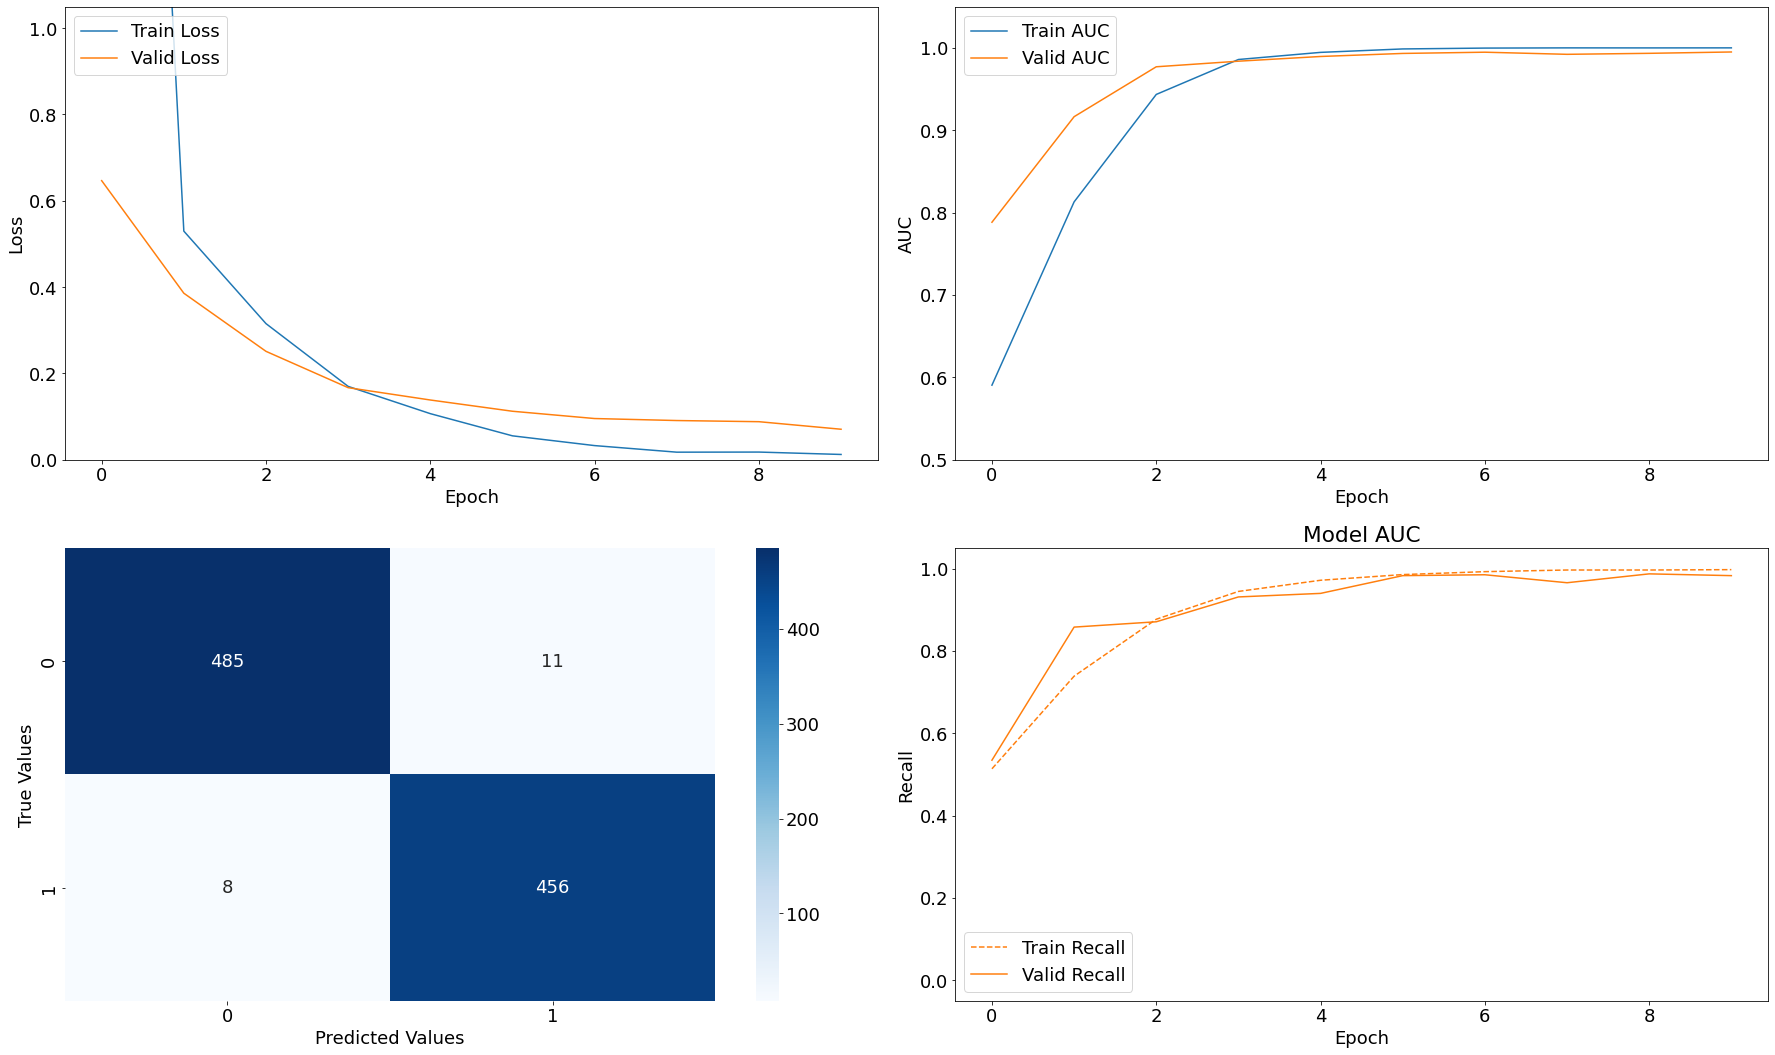

In [ ]:
evaluate(final_model, 'final_model', final_history, X=test_images, y=test_labels, threshold=0.5)

Our final model performs quite well on test data, despite remaining somewhat overfit. It yields an accuracy of ~98% and recall of ~98%, while only producing 8 false negatives through its predictions. This equates to a false-negative rate of under 1%. Perhaps something that can be done is adjusting the ROC threshold to minimize false negatives even further, at the cost of a greater amount of false positives. This would have to be done post-processing, and cannot be specified in the model training process.

## Model Deployment - Gradio

I used Gradio to temporarily deploy a functional web-app version of the model running locally off of this notebook. Unfortunately, more permanent cloud-based hosting was untenable given the size of the resulting model and a lack of necessary computing power. If interested in recreating the app, uncomment out the below cells after running the earlier cells to train the model. Note that one of the cells installs gradio, which is necessary if not yet installed.

In [ ]:
# from keras.preprocessing import image
# from keras import utils
# from PIL import Image

In [ ]:
# pip install gradio

In [ ]:
# import gradio as gr

# def img_class(input_img):
#     test_img = input_img.reshape(1, 256, 256, 3)
#     class_int = int(final_model.predict(test_img))
#     if class_int == 0:
#         class_str = 'Healthy'
#     else:
#         class_str = "Demented"
#     return class_str

# demo = gr.Interface(img_class, inputs=gr.Image(shape=(256, 256)), 
#                     outputs=gr.Textbox(label="Predicted Classification"), 
#                     allow_flagging='never', 
#                     title='Alzheimers Classification by Image Demo',
#                     description="Upload f-MRI."
#                    )
# demo.launch(share=True, debug=True)

## Conclusion

My final model is able to diagnose Alzheimer's Disease with an accuracy superior to modern, tool-assisted, f-MRI interpretation conducted by radiologists and neurologists (98% accuracy). Furthermore, my model is designed to minimize false-negative diagnoses and does so with a false-negative rate of under 1%.

Given its speed and accuracy, the machine learning tool I've developed shows considerable promise in guiding physician decisions.

## Next Steps
1.   The model can continue to learn and adjust with new patient data. Training the model on additional patient data, including past and future data, will help improve the model's accuracy and fine-tune the model's performance for the hospital's patients.
2.   The current model will need to be integrated with a hospital's IT system to maintain patient confidentiality, ensure HIPAA compliancy, and create efficient workflows. I recommend testing the current model with a pilot system under supervision from experts. This period will both confirm the accuracy of the model and help adjust any system processes.
3.   It could be beneficial to train similar models using not only fMRI but also other imaging techniques, such as CT, PET, sMRI, and DTI. This would allow for further diagnostic confidence if each model were to return the same diagnosis. If there were to be a discrepancy or inconsistency between model predictions, it would signal experts to apply further scrutiny and consider using other diagnostic tools.


